In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv('data/df_ml.csv', sep=",")
#df['Date'] = pd.to_datetime(df['Date'])

#df.drop(index=1, inplace=True)
df.head(3)

,Open,High,Low,Close,Adj Close,Volume($),Symbol,Daily Return,SMA_30,SMA_60,...,Close_rolling_std_7,Volume_rolling_mean_7,Volume_rolling_std_7,Close_rolling_mean_30,Close_rolling_std_30,Volume_rolling_mean_30,Volume_rolling_std_30,Year,Month,Day
0,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,BTC,0.012842,22428.243750,19715.608773,...,1284.059118,4.970113e+10,8.115395e+09,22428.243750,3661.566866,3.886562e+10,1.223869e+10,2021,1,1
1,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,BTC,0.093726,22850.972721,20018.558219,...,1936.633106,5.249153e+10,1.055716e+10,22850.972721,4019.854985,4.006346e+10,1.325301e+10,2021,1,2
2,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,BTC,0.020380,23320.381315,20329.363493,...,2189.909798,5.423229e+10,1.376529e+10,23320.381315,4328.735995,4.155655e+10,1.494648e+10,2021,1,3


In [4]:
df = df[['Symbol','Close', 'Close_lag_1', 'Low','Midpoint','High','Open','Close_lag_3']] #
#df = df[['Close','Symbol','Close_lag_7','EMA_90', '90_day_MA', 'Close_rolling_mean_30','EMA_60','EMA_26','SMA_30']]
#df.head(1)



28             Close_lag_7        1
12                  EMA_90        1
23               90_day_MA        1
34   Close_rolling_mean_30        1
11                  EMA_60        2
15                  EMA_26        3
7                   SMA_30        4

In [5]:
df

,Symbol,Close,Close_lag_1,Low,Midpoint,High,Open,Close_lag_3
0,BTC,29374.152344,29001.720703,28803.585938,29202.106445,29600.626953,28994.009766,27362.437500
1,BTC,32127.267578,29374.152344,29091.181641,31123.149414,33155.117188,29376.455078,28840.953125
2,BTC,32782.023438,32127.267578,32052.316406,33330.437500,34608.558594,32129.408203,29001.720703
3,BTC,31971.914062,32782.023438,28722.755859,31081.487305,33440.218750,32810.949219,29374.152344
4,BTC,33992.429688,31971.914062,30221.187500,32329.388672,34437.589844,31977.041016,32127.267578
...,...,...,...,...,...,...,...,...
16039,TON,2.160291,2.135291,2.101517,2.132578,2.163639,2.143799,2.045980
16040,TON,2.587086,2.160291,2.156239,2.397342,2.638445,2.159645,2.092255
16041,TON,2.539670,2.587086,2.424762,2.578523,2.732283,2.592313,2.135291
16042,TON,2.425865,2.539670,2.418916,2.483391,2.547866,2.544140,2.160291


#### Onehot encoding 

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)


artists_column = df['Symbol'].values.reshape(-1, 1)

one_hot_encoded_artists = one_hot_encoder.fit_transform(artists_column)

df['Symbol'] = np.argmax(one_hot_encoded_artists, axis=1)

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Scaling and Spliting train,test,validation

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into features (X) and target variable (y)
X = df.drop('Close', axis=1)  
y = df['Close']

# Split the dataset into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)


## Machine Learning Models

### LSTM

In [8]:
lstm_test = df

In [9]:
#pip install tensorflow


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable

# Ensure you're using a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [26]:
# Assuming lstm_test is your dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
lstm_test_scaled = scaler.fit_transform(np.array(lstm_test).reshape(-1, 1))

train_size = int(len(lstm_test_scaled) * 0.65)
test_size = len(lstm_test_scaled) - train_size
train_data, test_data = lstm_test_scaled[0:train_size, :], lstm_test_scaled[train_size:len(lstm_test_scaled), :]


In [36]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming the preprocessing and dataset creation steps have been completed
# And you have X_train, Y_train, X_test, Y_test

# Convert arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float().unsqueeze(-1)  # Add an extra dimension
Y_train_tensor = torch.tensor(Y_train).float()
X_test_tensor = torch.tensor(X_test).float().unsqueeze(-1)  # Add an extra dimension
Y_test_tensor = torch.tensor(Y_test).float()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Define your batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [37]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Initialize the model
model = LSTMModel(input_dim=1, hidden_dim=50, num_layers=1, output_dim=1).to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [38]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')


C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.02551858804629518
Epoch 11, Loss: 0.025529913785057538
Epoch 21, Loss: 0.025438469429787416
Epoch 31, Loss: 0.025444579509736668
Epoch 41, Loss: 0.02544003824572674
Epoch 51, Loss: 0.02543543221703219
Epoch 61, Loss: 0.025437909308575972
Epoch 71, Loss: 0.025437324313670767
Epoch 81, Loss: 0.025454029202684417
Epoch 91, Loss: 0.0254535440960595


In [41]:
model.eval()  # Set the model to evaluation mode
test_predictions = []
test_targets = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        test_predictions.extend(outputs.cpu().detach().numpy())
        test_targets.extend(labels.cpu().detach().numpy())

# Convert predictions and targets list to numpy arrays
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)


In [42]:
# Assuming your scaler was fit on the original data
# You might need to reshape your data for the inverse transformation if it's required by your scaler
test_predictions_inverse = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_targets_inverse = scaler.inverse_transform(test_targets.reshape(-1, 1))


In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test_targets_inverse, test_predictions_inverse)
rmse = sqrt(mse)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MSE: 0.0005631362437270582
RMSE: 0.02373049185598685


In [44]:
def generate_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            predictions.extend(outputs.cpu().detach().numpy())
            actuals.extend(labels.cpu().detach().numpy())
    
    return np.array(predictions), np.array(actuals)

# Generate predictions and actuals for both training and testing datasets
train_predictions, train_actuals = generate_predictions(model, train_loader)
test_predictions, test_actuals = generate_predictions(model, test_loader)


In [45]:
train_predictions_inverse = scaler.inverse_transform(train_predictions.reshape(-1, 1))
train_actuals_inverse = scaler.inverse_transform(train_actuals.reshape(-1, 1))
test_predictions_inverse = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inverse = scaler.inverse_transform(test_actuals.reshape(-1, 1))


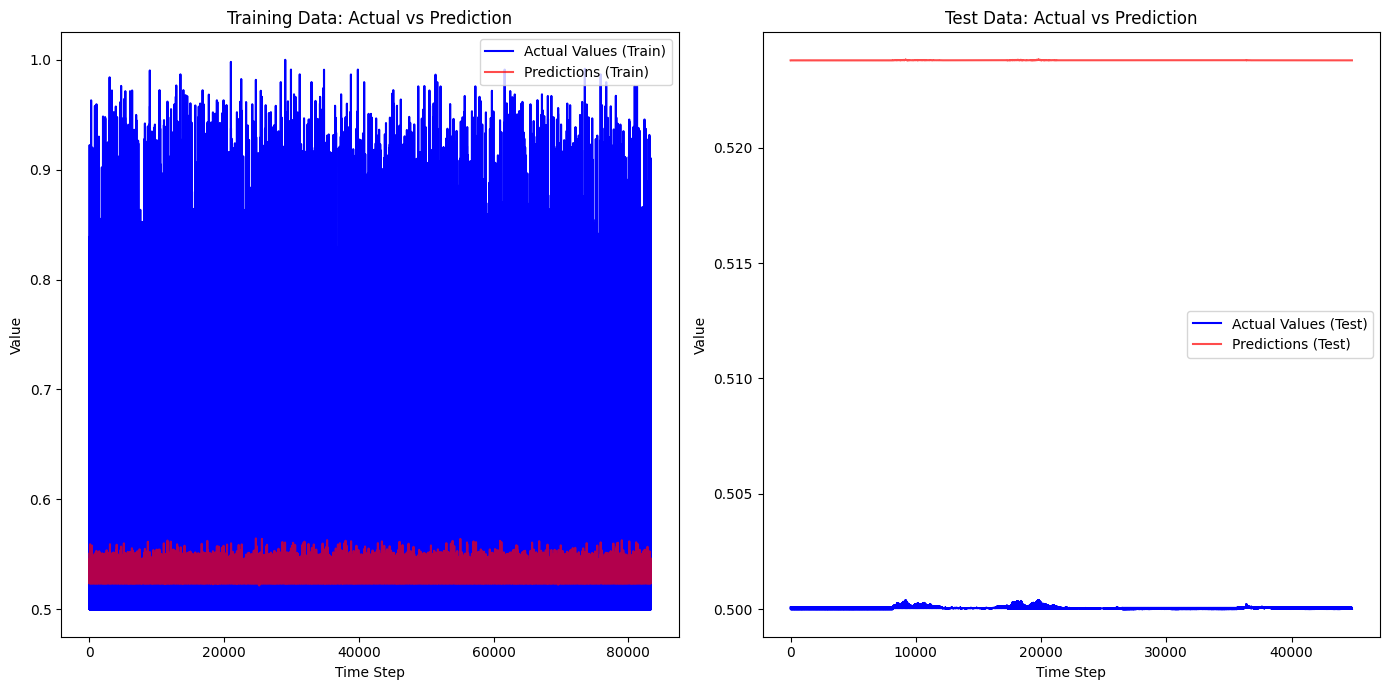

In [46]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 7))

# Training data plot
plt.subplot(1, 2, 1)
plt.plot(train_actuals_inverse, label='Actual Values (Train)', color='blue')
plt.plot(train_predictions_inverse, label='Predictions (Train)', color='red', alpha=0.7)
plt.title('Training Data: Actual vs Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

# Test data plot
plt.subplot(1, 2, 2)
plt.plot(test_actuals_inverse, label='Actual Values (Test)', color='blue')
plt.plot(test_predictions_inverse, label='Predictions (Test)', color='red', alpha=0.7)
plt.title('Test Data: Actual vs Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
#PyTorch Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [28]:
# Convert the X_train, Y_train, X_test, Y_test to Tensors
X_train_tensor = torch.Tensor(X_train).unsqueeze(-1).to(device)
Y_train_tensor = torch.Tensor(Y_train).unsqueeze(-1).to(device)
X_test_tensor = torch.Tensor(X_test).unsqueeze(-1).to(device)
Y_test_tensor = torch.Tensor(Y_test).unsqueeze(-1).to(device)


In [29]:
input_dim = 1
hidden_dim = 50
num_layers = 3
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [34]:
#torch.cuda.empty_cache()


In [35]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


OutOfMemoryError: CUDA out of memory. Tried to allocate 31.25 GiB. GPU 0 has a total capacity of 4.00 GiB of which 390.64 MiB is free. Of the allocated memory 2.20 GiB is allocated by PyTorch, and 1.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pytorch.keras.models import Sequential
from pytorch.keras.layers import Dense
from pytorch.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'pytorch'

In [11]:
scaler = MinMaxScaler()
lstm_test = scaler.fit_transform(np.array(lstm_test).reshape(-1,1))
lstm_test.shape

(128352, 1)

In [12]:
train_size = int(len(lstm_test)*0.65)
test_size = len(lstm_test) - train_size
train_data,test_data = lstm_test[0:train_size,:],lstm_test[train_size:len(lstm_test),:1]

In [13]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [14]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [15]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(83327, 100)
[[4.36112277e-05 4.27014282e-01 4.21600215e-01 ... 5.42470749e-01
  4.93140658e-01 4.73685792e-01]
 [4.27014282e-01 4.21600215e-01 4.18719915e-01 ... 4.93140658e-01
  4.73685792e-01 5.10139639e-01]
 [4.21600215e-01 4.18719915e-01 4.24513238e-01 ... 4.73685792e-01
  5.10139639e-01 5.46593486e-01]
 ...
 [1.88264580e-06 1.99316389e-06 1.77784072e-06 ... 1.66136971e-06
  1.58605313e-06 1.78922331e-06]
 [1.99316389e-06 1.77784072e-06 1.68534135e-06 ... 1.58605313e-06
  1.78922331e-06 1.59907835e-04]
 [1.77784072e-06 1.68534135e-06 1.59907835e-04 ... 1.78922331e-06
  1.59907835e-04 1.47509162e-06]]
(44823, 100)
(44823,)


In [16]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:


model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
1302/1302 [==============================] - 66133s 51s/step - loss: 0.0033 - val_loss: 1.5527e-05
Epoch 2/100
1302/1302 [==============================] - 246s 189ms/step - loss: 8.2190e-04 - val_loss: 1.5356e-06
Epoch 3/100
1302/1302 [==============================] - 255s 196ms/step - loss: 1.1732e-04 - val_loss: 2.6308e-05
Epoch 4/100
1302/1302 [==============================] - 256s 196ms/step - loss: 1.0391e-04 - val_loss: 9.1435e-08
Epoch 5/100
1302/1302 [==============================] - 253s 194ms/step - loss: 9.5678e-05 - val_loss: 7.4417e-07
Epoch 6/100
1302/1302 [==============================] - 267s 205ms/step - loss: 7.6695e-05 - val_loss: 5.1587e-06
Epoch 7/100
 886/1302 [===================>..........] - ETA: 1:10 - loss: 6.2022e-05

KeyboardInterrupt: 

In [22]:
import torch

# Print PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check for CUDA (GPU support)
if torch.cuda.is_available():
    print("CUDA is available. GPU(s) detected:")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print("PyTorch will use GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch will run on CPU.")


PyTorch version: 2.2.1+cu118
CUDA is available. GPU(s) detected:
Number of GPUs available: 1
GPU 0: GeForce GTX 1650
PyTorch will use GPU: GeForce GTX 1650


In [ ]:
train_predict = model.predict(X_train)
test_predict = model. Predict(X_test)

In [ ]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

In [ ]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

### Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize the model
linear_reg = LinearRegression()


linear_reg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = linear_reg.predict(X_test_scaled)

mse_lr = mean_squared_error(y_test, y_pred)
print(f"Linear Regression MSE: {mse_lr}")


Linear Regression MSE: 19942.264549365093


In [24]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.9998187610689385
Mean Absolute Error (MAE): 30.318067887842968
Root Mean Squared Error (RMSE): 141.21708306492204


##### Cross-Validation for Linear Regression

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Initialize the model
linear_reg = LinearRegression()

# Perform cross-validation
cv_scores_lr = cross_val_score(linear_reg, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean MSE
mean_mse_lr = -cv_scores_lr.mean()
print(f"Linear Regression Cross-Validated MSE: {mean_mse_lr}")


Linear Regression Cross-Validated MSE: 21423.389740088758


#### Grid Search
Grid Search evaluates all the provided combinations of hyperparameters, which can be computationally expensive but thorough.

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the parameter distribution
param_dist = {
    'n_estimators': [80, 100, 120, 140],
    'max_depth': [20, 30, 40, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

# Initialize the base model
rf = RandomForestRegressor(random_state=42)

# Initialize the randomized search model
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1,
                                   scoring='neg_mean_squared_error')

# Fit the randomized search model
random_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", np.sqrt(-random_search.best_score_))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Best score found:  195.77046215036302


In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
model = RandomForestRegressor(random_state=42)

param_distributions = {
    'n_estimators': randint(100, 500),  # Number of trees in the forest
    'max_depth': randint(10, 50),  # Maximum depth of the tree
    'min_samples_split': randint(2, 11),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 11),  # Minimum number of samples required to be at a leaf node
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Controls the verbosity: the higher, the more messages
    random_state=42,
    n_jobs=-1,  # Number of jobs to run in parallel (-1 means using all processors)
    scoring='neg_mean_squared_error'  # Change according to your needs
)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", -random_search.best_score_)

best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 275}
Best score found:  38651.833918261735
Test MSE: 34268.50814304979


In [33]:
# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.9996885615588167
Mean Absolute Error (MAE): 41.22077809745639
Root Mean Squared Error (RMSE): 185.11755222844155


In [35]:
# Assuming you have X_independent_test and y_independent_test prepared
y_pred_independent = random_forest.predict(X_independent_test_scaled)

# Calculate metrics
mse_independent = mean_squared_error(y_independent_test, y_pred_independent)
r2_independent = r2_score(y_independent_test, y_pred_independent)
mae_independent = mean_absolute_error(y_independent_test, y_pred_independent)

print(f"Independent Test MSE: {mse_independent}")
print(f"Independent Test R-squared: {r2_independent}")
print(f"Independent Test MAE: {mae_independent}")


NameError: name 'X_independent_test_scaled' is not defined

In [34]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize model (assuming best parameters are already set)
model = RandomForestRegressor(
    max_depth=12, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=275,
    random_state=42)

mse_scores = []
r2_scores = []
mae_scores = []

for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

# Calculate average scores
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")


Average MSE: 504017.42934379855
Average R-squared: -17.12640306626498
Average MAE: 211.3903191462378


### Decision Trees and Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model with the best parameters from Grid Search
random_forest = RandomForestRegressor(
    n_estimators=120,  # Best number of trees
    max_depth=30,  # Best maximum depth of trees
    min_samples_leaf=1,  # Best minimum number of samples required at a leaf node
    min_samples_split=2,  # Best minimum number of samples required to split an internal node
    random_state=42  # For reproducibility
)

# Fit the model with the training data
random_forest.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = random_forest.predict(X_test_scaled)

# Evaluate the model with the test data
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE with Best Parameters: {mse_rf}")




Random Forest MSE with Best Parameters: 33160.30784583442


In [32]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Calculate R-squared
r_squared = r2_score(y_test, y_pred_rf)
print(f"R-squared: {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_rf)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.999698633084885
Mean Absolute Error (MAE): 40.328240554986756
Root Mean Squared Error (RMSE): 182.09971951058688


##### Cross-Validation for Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores_rf = cross_val_score(random_forest, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean MSE
mean_mse_rf = -cv_scores_rf.mean()
print(f"Random Forest Cross-Validated MSE: {mean_mse_rf}")


Random Forest Cross-Validated MSE: 96922514.69028388


### Gradient Boosting Machines (GBM)

#### Random Search
Random Search samples a given number of candidates from a parameter space with a specified distribution. It's less comprehensive but much faster than Grid Search.

In [223]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter distribution to sample from
param_dist = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.3, 0.7],
    'subsample': [0.6, 0.9]
}

# Initialize the XGBRegressor
xg_reg = xgb.XGBRegressor()

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg_reg, param_distributions=param_dist, n_iter=25, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", -random_search.best_score_)


Best parameters found:  {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best score found:  39292.73854500158


In [234]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Adjusting the model with the best parameters found
xg_reg_optimized = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.7,  # Updated from 0.3 to 0.7 based on the best parameters
    learning_rate=0.1,     # Remains the same as before
    max_depth=5,           # Remains the same as before
    alpha=10,              # Remains the same as before
    n_estimators=500,      # Updated from 10 to 500 based on the best parameters
    subsample=0.8          # Added based on the best parameters
)

# Fit the model with the adjusted parameters
xg_reg_optimized.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_optimized = xg_reg_optimized.predict(X_test_scaled)

# Evaluate the model with the adjusted parameters
mse_xgb_optimized = mean_squared_error(y_test, y_pred_optimized)
print(f"Optimized XGBoost MSE: {mse_xgb_optimized}")


Optimized XGBoost MSE: 32797.58750307243


In [235]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Calculate R-squared
r_squared = r2_score(y_test, y_pred_optimized)
print(f"R-squared: {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_optimized)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.9997019295533995
Mean Absolute Error (MAE): 39.37663597807381
Root Mean Squared Error (RMSE): 181.10104224733888


##### Cross-Validation for XGBoost

In [236]:
import xgboost as xgb

# Initialize the model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                max_depth=5, alpha=10, n_estimators=10)

# Perform cross-validation
cv_scores_xgb = cross_val_score(xg_reg, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean MSE
mean_mse_xgb = -cv_scores_xgb.mean()
print(f"XGBoost Cross-Validated MSE: {mean_mse_xgb}")


XGBoost Cross-Validated MSE: 98328661.26877618


### LazyPredict

In [13]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle

# Shuffle your dataset (optional but recommended for cross-sectional data)
#X, y = shuffle(X, y, random_state=42)

# Split the dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and compare models
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the performance of each model
print(models)


 74%|███████▍  | 31/42 [01:05<00:13,  1.18s/it]

In [ ]:
df.to_csv('data/df_fs.csv', index=False)